In [88]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM, MORCGP
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import MinCovDet

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [89]:
df = pd.read_csv('cisplatin_GDSC1.csv')
df

,Unnamed: 0,drug,cell_line,name,tissue,histology,log10_dose,viability
0,1,CISPLATIN,924238,K5,thyroid,carcinoma,-1.408240,0.931629
1,2,CISPLATIN,924238,K5,thyroid,carcinoma,-1.107210,0.772518
2,3,CISPLATIN,924238,K5,thyroid,carcinoma,-0.806180,0.747044
3,4,CISPLATIN,924238,K5,thyroid,carcinoma,-0.505150,0.856572
4,5,CISPLATIN,924238,K5,thyroid,carcinoma,-0.204120,0.878915
...,...,...,...,...,...,...,...,...
8590,8591,CISPLATIN,688026,NCI-H64,lung,carcinoma,-0.425969,0.980248
8591,8592,CISPLATIN,688026,NCI-H64,lung,carcinoma,-0.124939,0.958733
8592,8593,CISPLATIN,688026,NCI-H64,lung,carcinoma,0.176091,0.905251
8593,8594,CISPLATIN,688026,NCI-H64,lung,carcinoma,0.477121,0.921236


In [90]:
def preprocess_data(df, cell_lines):
    # Keep only the relevant columns
    df_copy = df[['cell_line', 'log10_dose', 'viability']]

    # Subset by the given cell_lines directly
    df_subset = df_copy[df_copy['cell_line'].isin(cell_lines)]

    # Pivot
    pivoted = df_subset.pivot(index='cell_line', columns='log10_dose', values='viability')

    # Reorder rows to match the order of `cell_lines` provided
    pivoted = pivoted.loc[cell_lines]

    Y = pivoted.to_numpy()
    x = pivoted.columns.to_numpy().reshape(-1, 1)

    return x, Y.T

# list_cell_lines = [1479988, 910700, 1240223, 909778, 1240220, 905981, 907319, 905935]
# list_cell_lines = [1479988, 910700, 905935]
list_cell_lines = [1479988, 910700, 905935]
# list_cell_lines = [1479988, 910700]
# list_cell_lines = [1479988, 910700, 905935, 1240223]
list_cell_lines = [1479988, 905935]
x, Y = preprocess_data(df, list_cell_lines)

In [44]:
def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Shared signal: induces positive correlations
    shared_component = base_strength * np.ones((d, r))
    # Small random noise to avoid exact collinearity
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

def cov_to_corr(cov):
    stddev = np.sqrt(np.diag(cov))        # standard deviations
    corr = cov / np.outer(stddev, stddev) # normalize
    return corr

Optimized length_scale: 1.0847
Optimized noise: [0.01344746 0.0036167 ]
Optimized A: [[-0.38717132]
 [-0.41691528]]
Optimized B: 
[[0.14990163 0.16141764]
 [0.16141764 0.17381835]]


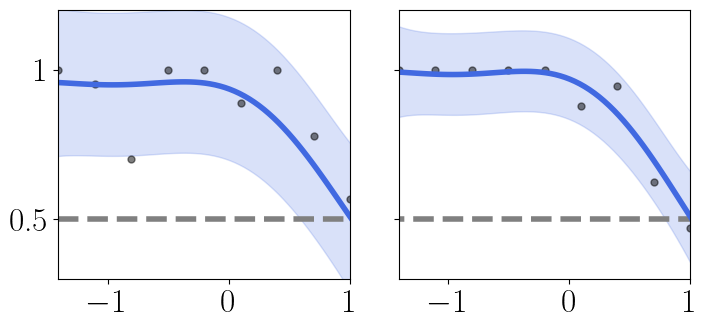

In [91]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 0.2
init_noise_var = np.array([0.1]*n_outputs) 
init_A = generate_A(d=n_outputs, r=1, noise_level=0.1, seed=42)
# print("A:\n", init_A)
# print("B:\n", init_A @ init_A.T)

# Instantiate and train
mogp = MOGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=init_A)
# mogp = MOGPRegressor_NC(mean=prior_mean, length_scale=init_length_scale, noise=0.01, A=init_A)
mogp.fit(x, Y)
# Optimize hyperparameters
mogp.optimize_hyperparameters(print_opt_param=True)
# mogp.optimize_loo_cv()

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

optim_length_scale = mogp.length_scale
optim_A = mogp.A
optim_B = mogp.B
optim_noise = mogp.noise

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4)) 

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.3, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1']) 
    else:
        axs[i].set_yticklabels([]) 

# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

[[1.         0.97294128]
 [0.97294128 1.        ]]
[[0.02104362 0.02705916]
 [0.02705916 0.03675656]]
Optimized length_scale: 1.0763
Optimized noise_var: [0.01340968 0.00359984]
Optimized A: [[-0.40251744]
 [-0.41053727]]
Optimized B: 
[[0.16202029 0.16524841]
 [0.16524841 0.16854085]]


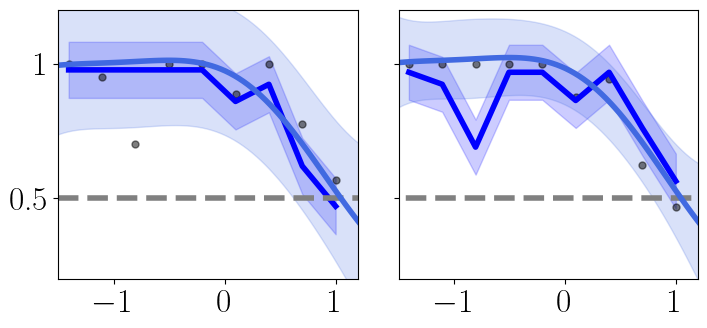

In [92]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 1.9325
init_noise_var = np.array([0.1]*n_outputs)

Y_clean = Y[~np.isnan(Y).any(axis=1)]
mcd = MinCovDet(support_fraction=0.9).fit(Y_clean)
robust_covariance = mcd.covariance_
empty_noise = np.array([1e-6]*n_outputs)
print(cov_to_corr(robust_covariance))
print(robust_covariance)

morcgp = MORCGP(mean=prior_mean, length_scale=optim_length_scale, noise_var=optim_noise, A=optim_A)
# init_gamma, init_c = morcgp.fit(x, Y, epsilons=np.array([3/9, 2/9]))
init_gamma, init_c = morcgp.fit(x, Y, epsilons=np.array([1/9, 1/9, 0]))
gamma, c = morcgp.optimize_loo_cv(print_opt_param = True, print_iter_objective=False, k=1, init_cov=robust_covariance, fix_weights=True)

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    # axs[i].plot(x.flatten(), init_gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), init_gamma[:, i] - init_c[:, i], init_gamma[:, i] + init_c[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x.flatten(), gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x.flatten(), gamma[:, i] - c[:, i], gamma[:, i] + c[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.2, 1.2])
    axs[i].set_xlim([-1.5, 1.2])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])
    else:
        axs[i].set_yticklabels([])

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

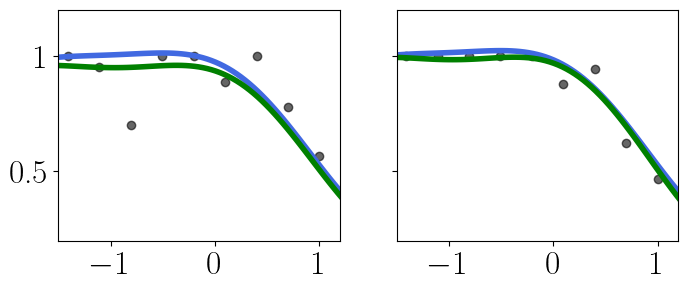

In [93]:
# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 3))

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.6, markersize=6)

    # axs[i].plot(x.flatten(), init_gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), init_gamma[:, i] - init_c[:, i], init_gamma[:, i] + init_c[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    

    # axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    # axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
    #                     color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='Predicted Mean')
    # axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], 
    #                     color='green', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.2, 1.2])
    axs[i].set_xlim([-1.5, 1.2])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])
    else:
        axs[i].set_yticklabels([])

# GDSC2

In [70]:
df = pd.read_csv('cisplatin_GDSC2.csv')
df

,Unnamed: 0,drug,cell_line,name,tissue,histology,log10_dose,viability
0,1,CISPLATIN,910784,A204,soft_tissue,rhabdomyosarcoma,-2.397711,0.992174
1,2,CISPLATIN,910784,A204,soft_tissue,rhabdomyosarcoma,-2.221620,0.994991
2,3,CISPLATIN,910784,A204,soft_tissue,rhabdomyosarcoma,-1.897749,0.999169
3,4,CISPLATIN,910784,A204,soft_tissue,rhabdomyosarcoma,-1.721658,1.000000
4,5,CISPLATIN,910784,A204,soft_tissue,rhabdomyosarcoma,-1.397787,1.000000
...,...,...,...,...,...,...,...,...
10922,10923,CISPLATIN,907795,LS-513,large_intestine,carcinoma,-1.397787,0.977202
10923,10924,CISPLATIN,907795,LS-513,large_intestine,carcinoma,-0.897826,1.000000
10924,10925,CISPLATIN,907795,LS-513,large_intestine,carcinoma,-0.397864,0.930329
10925,10926,CISPLATIN,907795,LS-513,large_intestine,carcinoma,0.102098,0.943530


In [84]:
def preprocess_data(df, cell_lines):
    # Keep only the relevant columns
    df_copy = df[['cell_line', 'log10_dose', 'viability']]

    # Subset by the given cell_lines directly
    df_subset = df_copy[df_copy['cell_line'].isin(cell_lines)]

    # Pivot
    pivoted = df_subset.pivot(index='cell_line', columns='log10_dose', values='viability')

    # Reorder rows to match the order of `cell_lines` provided
    pivoted = pivoted.loc[cell_lines]

    Y = pivoted.to_numpy()
    x = pivoted.columns.to_numpy().reshape(-1, 1)

    return x, Y.T

# list_cell_lines = [910079, 1480362, 946361, 713880, 907312, 1240196]
# list_cell_lines = [910079, 1480362, 946361]
# list_cell_lines = [910079, 1480362]
# list_cell_lines = [908446, 905935, 713880]

# list_cell_lines = [906865, 906830, 909725, 909784]
list_cell_lines = [906865, 909784]
x, Y = preprocess_data(df, list_cell_lines)

Optimized length_scale: 2.5051
Optimized noise: [0.00582757 0.00382752]
Optimized A: [[-0.29086464]
 [-0.30016106]]
Optimized B: 
[[0.08460224 0.08730624]
 [0.08730624 0.09009666]]


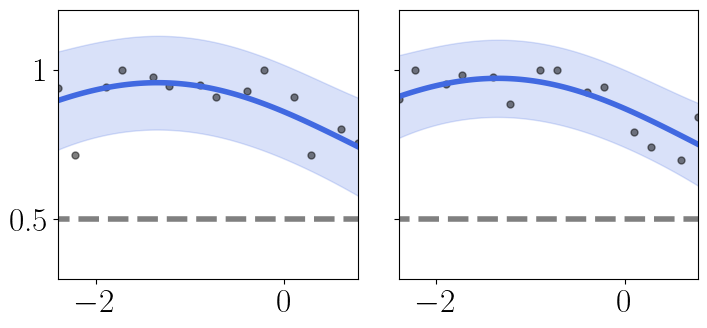

In [85]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 0.2
init_noise_var = np.array([0.1]*n_outputs) 
init_A = generate_A(d=n_outputs, r=1, noise_level=0.1, seed=42)
# print("A:\n", init_A)
# print("B:\n", init_A @ init_A.T)

# Instantiate and train
mogp = MOGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=init_A)
# mogp = MOGPRegressor_NC(mean=prior_mean, length_scale=init_length_scale, noise=0.01, A=init_A)
mogp.fit(x, Y)
# Optimize hyperparameters
mogp.optimize_hyperparameters(print_opt_param=True)
# mogp.optimize_loo_cv()

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

optim_length_scale = mogp.length_scale
optim_A = mogp.A
optim_B = mogp.B
optim_noise = mogp.noise

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4)) 

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.3, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1']) 
    else:
        axs[i].set_yticklabels([]) 

# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

[[1.         0.39782721]
 [0.39782721 1.        ]]
[[0.00096105 0.00075339]
 [0.00075339 0.00373173]]
Optimized length_scale: 2.5049
Optimized noise_var: [0.00582848 0.00382746]
Optimized A: [[-0.28976512]
 [-0.3009644 ]]
Optimized B: 
[[0.08396383 0.08720898]
 [0.08720898 0.09057957]]


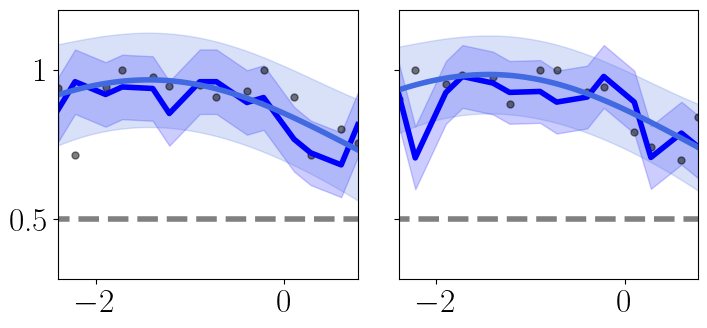

In [86]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 1.9325
init_noise_var = np.array([0.1]*n_outputs)

Y_clean = Y[~np.isnan(Y).any(axis=1)]
mcd = MinCovDet(support_fraction=0.6).fit(Y_clean)
robust_covariance = mcd.covariance_
empty_noise = np.array([1e-6]*n_outputs)
print(cov_to_corr(robust_covariance))
print(robust_covariance)

morcgp = MORCGP(mean=prior_mean, length_scale=optim_length_scale, noise_var=optim_noise, A=optim_A)
# init_gamma, init_c = morcgp.fit(x, Y, epsilons=np.array([3/9, 2/9]))
init_gamma, init_c = morcgp.fit(x, Y, epsilons=np.array([1/9, 1/9, 0]))
gamma, c = morcgp.optimize_loo_cv(print_opt_param = True, print_iter_objective=False, k=1, init_cov=robust_covariance, fix_weights=True)

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    axs[i].plot(x.flatten(), init_gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x.flatten(), init_gamma[:, i] - init_c[:, i], init_gamma[:, i] + init_c[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    # axs[i].plot(x.flatten(), gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), gamma[:, i] - c[:, i], gamma[:, i] + c[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.3, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])
    else:
        axs[i].set_yticklabels([])

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

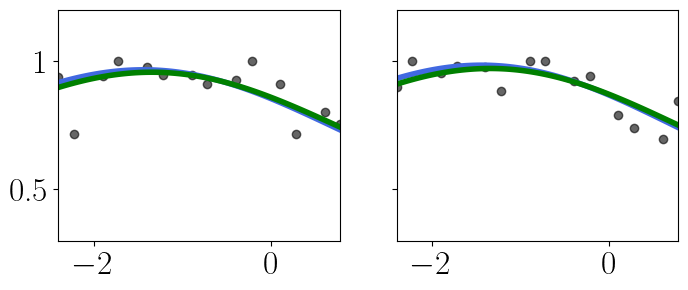

In [87]:
# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 3))

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.6, markersize=6)

    # axs[i].plot(x.flatten(), init_gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), init_gamma[:, i] - init_c[:, i], init_gamma[:, i] + init_c[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    

    # axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    # axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
    #                     color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='Predicted Mean')
    # axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], 
    #                     color='green', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.3, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])
    else:
        axs[i].set_yticklabels([])

# Merged

In [94]:
df = pd.read_csv('cisplatin.csv')
df

,Unnamed: 0,drug,cell_line,log10_dose,viability
0,1,CISPLATIN,924238,-2.397711,0.972837
1,2,CISPLATIN,924238,-2.221620,1.000000
2,3,CISPLATIN,924238,-1.897749,0.947334
3,4,CISPLATIN,924238,-1.721658,1.000000
4,5,CISPLATIN,924238,-1.408240,0.931629
...,...,...,...,...,...
19509,19510,CISPLATIN,908441,-0.221772,0.923064
19510,19511,CISPLATIN,908441,0.102098,1.000000
19511,19512,CISPLATIN,908441,0.278189,0.622700
19512,19513,CISPLATIN,908441,0.602060,0.847234


In [95]:
def preprocess_data(df, cell_lines):
    # Keep only the relevant columns
    df_copy = df[['cell_line', 'log10_dose', 'viability']]

    # Subset by the given cell_lines directly
    df_subset = df_copy[df_copy['cell_line'].isin(cell_lines)]

    # Pivot
    pivoted = df_subset.pivot(index='cell_line', columns='log10_dose', values='viability')

    # Reorder rows to match the order of `cell_lines` provided
    pivoted = pivoted.loc[cell_lines]

    Y = pivoted.to_numpy()
    x = pivoted.columns.to_numpy().reshape(-1, 1)

    return x, Y.T

list_cell_lines = [724838, 906865]
x, Y = preprocess_data(df, list_cell_lines)

Optimized length_scale: 1.2322
Optimized noise: [0.00911498 0.0067309 ]
Optimized A: [[-0.38449795]
 [-0.39068432]]
Optimized B: 
[[0.14783868 0.15021732]
 [0.15021732 0.15263424]]


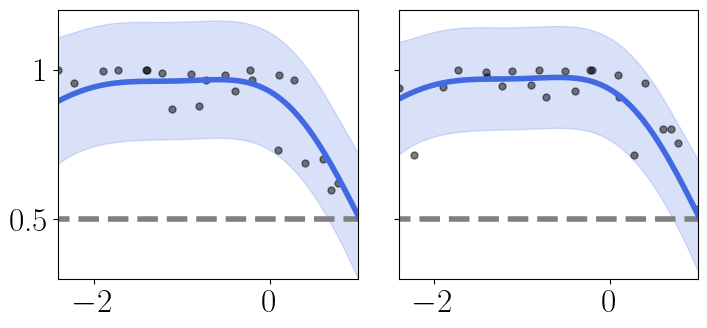

In [96]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 0.2
init_noise_var = np.array([0.1]*n_outputs) 
init_A = generate_A(d=n_outputs, r=1, noise_level=0.1, seed=42)
# print("A:\n", init_A)
# print("B:\n", init_A @ init_A.T)

# Instantiate and train
mogp = MOGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=init_A)
# mogp = MOGPRegressor_NC(mean=prior_mean, length_scale=init_length_scale, noise=0.01, A=init_A)
mogp.fit(x, Y)
# Optimize hyperparameters
mogp.optimize_hyperparameters(print_opt_param=True)
# mogp.optimize_loo_cv()

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

optim_length_scale = mogp.length_scale
optim_A = mogp.A
optim_B = mogp.B
optim_noise = mogp.noise

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4)) 

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)
    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.3, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1']) 
    else:
        axs[i].set_yticklabels([]) 

# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

[[ 1.         -0.20440215]
 [-0.20440215  1.        ]]
[[ 0.001903   -0.00028029]
 [-0.00028029  0.00098809]]


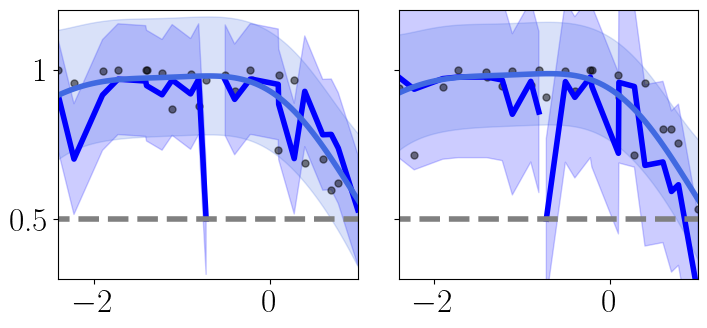

In [100]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 1.9325
init_noise_var = np.array([0.1]*n_outputs)

Y_clean = Y[~np.isnan(Y).any(axis=1)]
mcd = MinCovDet(support_fraction=0.6).fit(Y_clean)
robust_covariance = mcd.covariance_
empty_noise = np.array([1e-6]*n_outputs)
print(cov_to_corr(robust_covariance))
print(robust_covariance)

morcgp = MORCGP(mean=prior_mean, length_scale=optim_length_scale, noise_var=optim_noise, A=optim_A)
# init_gamma, init_c = morcgp.fit(x, Y, epsilons=np.array([3/9, 2/9]))
init_gamma, init_c = morcgp.fit(x, Y, epsilons=np.array([1/9, 1/9]))
# gamma, c = morcgp.optimize_loo_cv(print_opt_param = True, print_iter_objective=False, k=1, init_cov=robust_covariance, fix_weights=True)

# Predict on test points
x_test = np.linspace(-2.5, 1.5, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 4))

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.5)

    axs[i].plot(x.flatten(), init_gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x.flatten(), init_gamma[:, i] - init_c[:, i], init_gamma[:, i] + init_c[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    # axs[i].plot(x.flatten(), gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), gamma[:, i] - c[:, i], gamma[:, i] + c[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
                        color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.3, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])
    else:
        axs[i].set_yticklabels([])

# # Common axis labels
# fig.text(0.5, 0.04, 'log cisplatin dose', ha='center', fontsize=24)
# fig.text(0.04, 0.5, 'Viability', va='center', rotation='vertical', fontsize=24)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Leave room for the labels
plt.show()

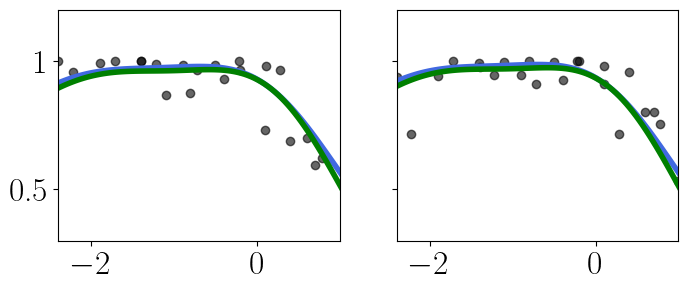

In [101]:
# Plotting
fig, axs = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 3))

for i in range(n_outputs):
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.6, markersize=6)

    # axs[i].plot(x.flatten(), init_gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x.flatten(), init_gamma[:, i] - init_c[:, i], init_gamma[:, i] + init_c[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    

    # axs[i].plot(x_test, prior_mean * np.ones((len(x_test), 1)), '--', color='grey')
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='Predicted Mean')
    # axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], 
    #                     color='royalblue', alpha=0.2, label='±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='Predicted Mean')
    # axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], 
    #                     color='green', alpha=0.2, label='±2 Std. Dev.')

    axs[i].set_ylim([0.3, 1.2])
    axs[i].set_xlim([x[0], x[-1]])
    axs[i].set_yticks([0.5, 1])

    if i == 0:
        axs[i].set_yticklabels(['0.5', '1'])
    else:
        axs[i].set_yticklabels([])